[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n_estimators=10, Accuracy=0.9594
n_estimators=60, Accuracy=0.9720
n_estimators=110, Accuracy=0.9748
n_estimators=160, Accuracy=0.9750
n_estimators=210, Accuracy=0.9757
n_estimators=260, Accuracy=0.9755
n_estimators=310, Accuracy=0.9753
n_estimators=360, Accuracy=0.9756
n_estimators=410, Accuracy=0.9755
n_estimators=460, Accuracy=0.9758
n_estimators=510, Accuracy=0.9755
n_estimators=560, Accuracy=0.9760
n_estimators=610, Accuracy=0.9760
n_estimators=660, Accuracy=0.9761
n_estimators=710, Accuracy=0.9762
n_estimators=760, Accuracy=0.9759
n_estimators=810, Accuracy=0.9758
n_estimators=860, Accuracy=0.9758
n_estimators=910, Accuracy=0.9757
n_estimators=960, Accuracy=0.9755


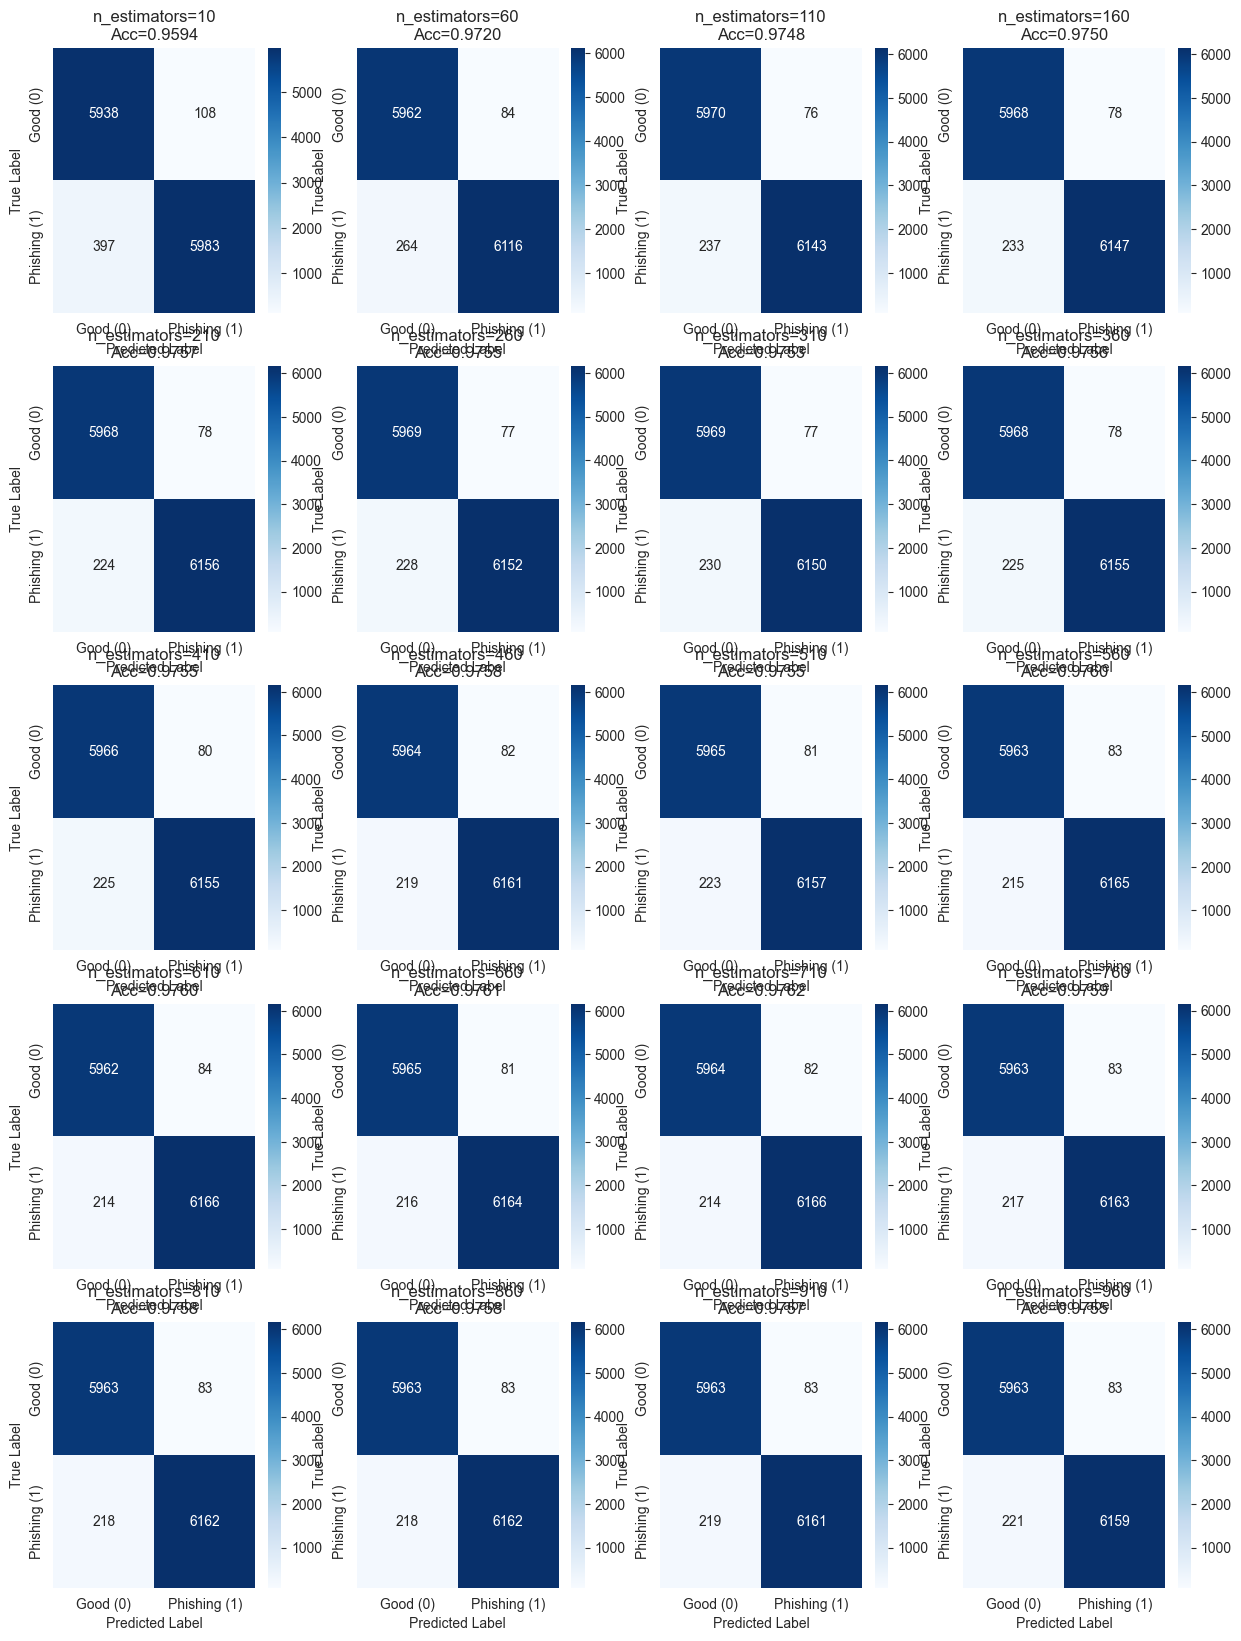

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset\data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset\balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

# Remove empty values
df_1 = df_1.dropna(subset=['body', 'subject', 'label'])
df_2 = df_2.dropna(subset=['body'])
df_3 = df_3.dropna(subset=['body', 'label'])

# Add missing columns
df_2['sender'] = ''
df_2['subject'] = ''
df_3['sender'] = ''
df_3['subject'] = ''

# Combine datasets
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df = df[df['label'].isin([0, 1])]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df['cleaned_sender'] = df['sender'].apply(clean_text)
df['cleaned_subject'] = df['subject'].apply(clean_text)
df['cleaned_body'] = df['body'].apply(clean_text)

# TF-IDF Vectorization
tfidf_sender = TfidfVectorizer()
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

X_sender = tfidf_sender.fit_transform(df['cleaned_sender'])
X_subject = tfidf_subject.fit_transform(df['cleaned_subject'])
X_body = tfidf_body.fit_transform(df['cleaned_body'])

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define range for n_estimators (10 to 1000, step size 50 for efficiency)
n_estimators_list = range(10, 1000, 50)

# Store results
confusion_matrices = {}
accuracies = {}

# Train models with different n_estimators
for n in n_estimators_list:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Compute and store metrics
    accuracies[n] = accuracy_score(y_test, y_pred)
    confusion_matrices[n] = confusion_matrix(y_test, y_pred)

    # Print progress
    print(f"n_estimators={n}, Accuracy={accuracies[n]:.4f}")

# Plot Confusion Matrices (in a grid)
n_plots = len(n_estimators_list)
n_cols = 4  # Number of columns in the grid
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, (n, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Good (0)', 'Phishing (1)'],
                yticklabels=['Good (0)', 'Phishing (1)'],
                ax=axes[idx])
    axes[idx].set_title(f"n_estimators={n}\nAcc={accuracies[n]:.4f}")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")